In [1]:
from functools import partial
import os
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection, sklearn.linear_model
from tqdm.contrib.concurrent import process_map

import postprocess
import utils

split_ratio_for_test = 0.3
split_ratio_for_postprocessing = 0.5  # among training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 43)

# This seed controls the randomness during pre-training (fixed)
seed_for_pretraining = 33

max_workers = 32

data_dir = "data/adult"

## Download UCI Adult dataset

In [2]:
features = [
    "Age", "Workclass", "fnlwgt", "Education", "Education-Num",
    "Martial Status", "Occupation", "Relationship", "Race", "Sex",
    "Capital Gain", "Capital Loss", "Hours per week", "Country", "Target"
]

# Download data
train_path = f"{data_dir}/adult.data"
test_path = f"{data_dir}/adult.test"
if any([not os.path.exists(p) for p in [train_path, test_path]]):
  os.makedirs(data_dir, exist_ok=True)
  urllib.request.urlretrieve(
      "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
      train_path)
  urllib.request.urlretrieve(
      "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
      test_path)

original_train = pd.read_csv(train_path,
                             names=features,
                             sep=r"\s*,\s*",
                             engine="python",
                             na_values="?")
original_test = pd.read_csv(test_path,
                            names=features,
                            sep=r"\s*,\s*",
                            engine="python",
                            na_values="?",
                            skiprows=1)
original = pd.concat([original_train, original_test])
original.drop(["fnlwgt"], inplace=True, axis=1)

# Binarize class labels, and remove it from the input data
labels_original = original[["Target"
                           ]].replace("<=50K.",
                                      "<=50K").replace(">50K.", ">50K")
original.drop(["Target"], inplace=True, axis=1)


def data_transform(df):
  """Normalize features"""
  binary_data = pd.get_dummies(df)
  scaler = sklearn.preprocessing.StandardScaler()
  data = pd.DataFrame(scaler.fit_transform(binary_data),
                      columns=binary_data.columns)
  data.index = df.index
  return data


# Transform data and encode labels as integers
data = data_transform(original)
label_names, labels = np.unique(labels_original, return_inverse=True)
n_classes = len(label_names)

In [3]:
def get_group_labels_and_print_statistics(sensitive_attributes):
  """Helper that returns group labels given (a list of) sensitive attributes."""

  df = original.copy()
  df["Target"] = np.array(label_names)[labels]
  groups = original[sensitive_attributes[0]]
  for attribute in sensitive_attributes[1:]:
    groups = np.add(np.add(groups, ", "), original[attribute])
  df["Group"] = groups
  df_grouped = df.groupby(["Target", "Group"]).size().unstack()
  counts = df_grouped.sum(axis=0)

  # Encode groups as integers
  group_names, groups = np.unique(groups, return_inverse=True)
  n_groups = len(group_names)

  print("Dataset statistics:")
  display(df_grouped / counts)
  display(pd.DataFrame(counts, columns=["Count"]).T)

  print("Perfect results if dataset equals population:")
  display(
      pd.DataFrame([{
          "alpha":
              np.inf,
          "accuracy":
              1.0,
          "delta_dp":
              utils.delta_dp(labels, groups),
          "delta_dp_rms":
              utils.delta_dp(
                  labels,
                  groups,
                  ord=2,
              ) / np.sqrt(n_classes)
      }, {
          "alpha":
              0.0,
          "accuracy":
              1 - postprocess.PostProcessorDP().fit(
                  scores=np.concatenate(
                      [np.eye(n_classes) for _ in range(n_groups)], axis=0),
                  groups=np.repeat(np.arange(n_groups), n_classes),
                  sample_weight=np.nan_to_num(
                      (df_grouped.to_numpy() / counts.to_numpy())).T.flatten(),
              ).score_,
          "delta_dp":
              0.0,
          "delta_dp_rms":
              0.0
      }]).groupby('alpha').agg('mean').sort_index(ascending=False))

  return groups, n_groups

## Gender as sensitive attribute

In [4]:
sensitive_attributes = ["Sex"]
groups, n_groups = get_group_labels_and_print_statistics(sensitive_attributes)

(data_, train_data_pre, labels_, train_labels_pre, groups_,
 train_groups_pre) = sklearn.model_selection.train_test_split(
     data,
     labels,
     groups,
     test_size=(1 - split_ratio_for_test) *
     (1 - split_ratio_for_postprocessing),
     random_state=seed_for_pretraining,
 )

n_samples = len(data)
n_pre = len(train_data_pre)
n_test = int(n_samples * split_ratio_for_test)
n_post = n_samples - n_pre - n_test

Dataset statistics:


Group,Female,Male
Target,,
<=50K,0.890749,0.696233
>50K,0.109251,0.303767


Group,Female,Male
Count,16192,32650


Perfect results if dataset equals population:


,accuracy,delta_dp,delta_dp_rms
alpha,,,
inf,1.000000,0.194516,0.194516
0.0,0.902742,0.000000,0.000000


In [5]:
# Train a logistic regression model on the pre-training data
predictor = sklearn.linear_model.LogisticRegression(
    random_state=seed_for_pretraining)
predictor.fit(train_data_pre, train_labels_pre)

# Get predicted probabilities
probas_ = predictor.predict_proba(data_)

  0%|          | 0/160 [00:00<?, ?it/s]

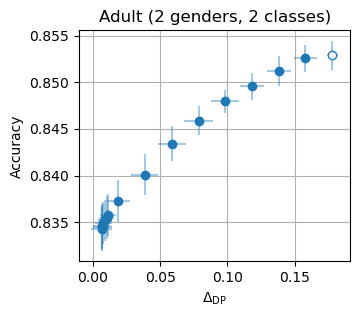

accuracy            delta_dp          
           mean       std      mean       std
alpha                                        
inf    0.852887  0.001553  0.178166  0.004148
0.160  0.852559  0.001423  0.157982  0.008669
0.140  0.851215  0.001648  0.138355  0.009146
0.120  0.849550  0.001456  0.118419  0.008800
0.100  0.847946  0.001222  0.098437  0.010290
0.080  0.845891  0.001563  0.078543  0.010565
0.060  0.843441  0.001854  0.058784  0.010610
0.040  0.840104  0.002226  0.038326  0.009959
0.020  0.837299  0.002210  0.018825  0.008739
0.010  0.835770  0.002250  0.011257  0.005811
0.008  0.835490  0.002283  0.010216  0.005484
0.006  0.835203  0.002210  0.008793  0.005410
0.004  0.834917  0.002240  0.007727  0.006255
0.002  0.834610  0.002345  0.007012  0.006688
0.001  0.834459  0.002444  0.006795  0.007140
0.000  0.834316  0.002363  0.006474  0.007593

In [6]:
alphas = [
    np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006,
    0.004, 0.002, 0.001, 0.0
]

return_vals = process_map(
    partial(
        utils.postprocess,
        postprocessor_factory=postprocess.PostProcessorDP,
        evaluate_fn=partial(utils.evaluate,
                            n_groups=n_groups,
                            n_classes=n_classes,
                            metrics=['delta_dp']),
        probas=probas_,
        labels=labels_,
        groups=groups_,
        n_post=n_post,
        n_test=n_test,
    ),
    [(alpha, seed) for alpha in alphas for seed in seeds],
    max_workers=max_workers,
)
results = [{
    'alpha': alpha,
    **result
} for alpha, _, result, _ in return_vals if result is not None]

(fig, ax), df = utils.plot_results(results, 'delta_dp')
ax.set_xlabel("$\\Delta_{\\mathrm{DP}}$")
ax.set_title("Adult (2 genders, 2 classes)")
plt.show()
display(df)

## Race as sensitive attribute

In [7]:
sensitive_attributes = ["Race"]
groups, n_groups = get_group_labels_and_print_statistics(sensitive_attributes)

(data_, train_data_pre, labels_, train_labels_pre, groups_,
 train_groups_pre) = sklearn.model_selection.train_test_split(
     data,
     labels,
     groups,
     test_size=(1 - split_ratio_for_test) *
     (1 - split_ratio_for_postprocessing),
     random_state=seed_for_pretraining,
 )

n_samples = len(data)
n_pre = len(train_data_pre)
n_test = int(n_samples * split_ratio_for_test)
n_post = n_samples - n_pre - n_test

# Train a logistic regression model on the pre-training data
predictor = sklearn.linear_model.LogisticRegression(
    random_state=seed_for_pretraining)
predictor.fit(train_data_pre, train_labels_pre)

# Get predicted probabilities
probas_ = predictor.predict_proba(data_)

Dataset statistics:


Group,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
Target,,,,,
<=50K,0.882979,0.730744,0.879189,0.876847,0.746013
>50K,0.117021,0.269256,0.120811,0.123153,0.253987


Group,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
Count,470,1519,4685,406,41762


Perfect results if dataset equals population:


,accuracy,delta_dp,delta_dp_rms
alpha,,,
inf,1.000000,0.152235,0.152235
0.0,0.942918,0.000000,0.000000


  0%|          | 0/210 [00:00<?, ?it/s]

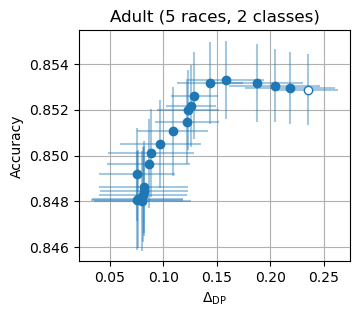

accuracy            delta_dp          
           mean       std      mean       std
alpha                                        
inf    0.852887  0.001553  0.234844  0.028283
0.220  0.852955  0.001568  0.218371  0.042224
0.200  0.853058  0.001595  0.203915  0.042168
0.180  0.853180  0.001695  0.187138  0.043023
0.150  0.853310  0.001711  0.158696  0.035205
0.120  0.853194  0.001793  0.143574  0.031165
0.100  0.852628  0.001891  0.128842  0.021891
0.090  0.852170  0.001778  0.125813  0.023463
0.080  0.852000  0.001744  0.123111  0.029189
0.070  0.851488  0.001851  0.122136  0.029536
0.060  0.851065  0.001958  0.108646  0.033118
0.050  0.850505  0.001907  0.097358  0.037419
0.040  0.850123  0.001930  0.088466  0.039861
0.030  0.849645  0.001948  0.086376  0.038843
0.020  0.849181  0.002024  0.075641  0.035764
0.010  0.848628  0.001997  0.081618  0.041672
0.008  0.848464  0.001975  0.082264  0.041011
0.005  0.848287  0.002083  0.081462  0.041043
0.002  0.848123  0.002141  0.076057  0.042135
0.001  0.848041  0.002182  0.075707  0.042665
0.000  0.848014  0.002175  0.080300  0.045165

In [8]:
alphas = [
    np.inf, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05,
    0.04, 0.03, 0.02, 0.01, 0.008, 0.005, 0.002, 0.001, 0.0
]

return_vals = process_map(
    partial(
        utils.postprocess,
        postprocessor_factory=postprocess.PostProcessorDP,
        evaluate_fn=partial(utils.evaluate,
                            n_groups=n_groups,
                            n_classes=n_classes,
                            metrics=['delta_dp']),
        probas=probas_,
        labels=labels_,
        groups=groups_,
        n_post=n_post,
        n_test=n_test,
    ),
    [(alpha, seed) for alpha in alphas for seed in seeds],
    max_workers=max_workers,
)
results = [{
    'alpha': alpha,
    **result
} for alpha, _, result, _ in return_vals if result is not None]

(fig, ax), df = utils.plot_results(results, 'delta_dp')
ax.set_xlabel("$\\Delta_{\\mathrm{DP}}$")
ax.set_title("Adult (5 races, 2 classes)")
plt.show()
display(df)

## Gender & race as sensitive attribute

In [9]:
sensitive_attributes = ["Sex", "Race"]
groups, n_groups = get_group_labels_and_print_statistics(sensitive_attributes)

(data_, train_data_pre, labels_, train_labels_pre, groups_,
 train_groups_pre) = sklearn.model_selection.train_test_split(
     data,
     labels,
     groups,
     test_size=(1 - split_ratio_for_test) *
     (1 - split_ratio_for_postprocessing),
     random_state=seed_for_pretraining,
 )

n_samples = len(data)
n_pre = len(train_data_pre)
n_test = int(n_samples * split_ratio_for_test)
n_post = n_samples - n_pre - n_test

# Train a logistic regression model on the pre-training data
predictor = sklearn.linear_model.LogisticRegression(
    random_state=seed_for_pretraining)
predictor.fit(train_data_pre, train_labels_pre)

# Get predicted probabilities
probas_ = predictor.predict_proba(data_)

Dataset statistics:


Group,"Female, Amer-Indian-Eskimo","Female, Asian-Pac-Islander","Female, Black","Female, Other","Female, White","Male, Amer-Indian-Eskimo","Male, Asian-Pac-Islander","Male, Black","Male, Other","Male, White"
Target,,,,,,,,,,
<=50K,0.918919,0.866538,0.942808,0.929032,0.88163,0.859649,0.660679,0.817417,0.844622,0.684531
>50K,0.081081,0.133462,0.057192,0.070968,0.11837,0.140351,0.339321,0.182583,0.155378,0.315469


Group,"Female, Amer-Indian-Eskimo","Female, Asian-Pac-Islander","Female, Black","Female, Other","Female, White","Male, Amer-Indian-Eskimo","Male, Asian-Pac-Islander","Male, Black","Male, Other","Male, White"
Count,185,517,2308,155,13027,285,1002,2377,251,28735


Perfect results if dataset equals population:


,accuracy,delta_dp,delta_dp_rms
alpha,,,
inf,1.000000,0.282129,0.282129
0.0,0.932797,0.000000,0.000000


  0%|          | 0/190 [00:00<?, ?it/s]

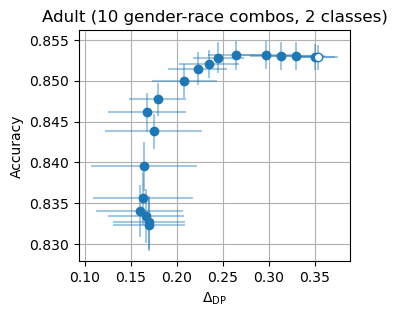

accuracy            delta_dp          
           mean       std      mean       std
alpha                                        
inf    0.852887  0.001553  0.353126  0.018779
0.350  0.852907  0.001624  0.350548  0.024833
0.320  0.853003  0.001704  0.329551  0.032070
0.300  0.853058  0.001740  0.312834  0.033515
0.280  0.853160  0.001691  0.296447  0.032988
0.250  0.853140  0.001766  0.264458  0.030958
0.220  0.852832  0.001868  0.245009  0.027541
0.200  0.852013  0.001719  0.235350  0.032724
0.180  0.851508  0.001977  0.222539  0.032410
0.150  0.849980  0.002119  0.207834  0.035274
0.120  0.847741  0.002011  0.178852  0.031225
0.100  0.846144  0.002412  0.166946  0.042443
0.080  0.843823  0.002153  0.174472  0.053039
0.050  0.839517  0.003020  0.164324  0.057376
0.020  0.835599  0.003229  0.163074  0.054589
0.010  0.834050  0.003240  0.159600  0.047250
0.005  0.833422  0.003284  0.165914  0.041462
0.001  0.832658  0.003229  0.169476  0.039110
0.000  0.832398  0.003221  0.169476  0.039110

In [10]:
alphas = [
    np.inf, 0.35, 0.32, 0.3, 0.28, 0.25, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08,
    0.05, 0.02, 0.01, 0.005, 0.001, 0.0
]

return_vals = process_map(
    partial(
        utils.postprocess,
        postprocessor_factory=postprocess.PostProcessorDP,
        evaluate_fn=partial(utils.evaluate,
                            n_groups=n_groups,
                            n_classes=n_classes,
                            metrics=['delta_dp']),
        probas=probas_,
        labels=labels_,
        groups=groups_,
        n_post=n_post,
        n_test=n_test,
    ),
    [(alpha, seed) for alpha in alphas for seed in seeds],
    max_workers=max_workers,
)
results = [{
    'alpha': alpha,
    **result
} for alpha, _, result, _ in return_vals if result is not None]

(fig, ax), df = utils.plot_results(results, 'delta_dp')
ax.set_xlabel("$\\Delta_{\\mathrm{DP}}$")
ax.set_title("Adult (10 gender-race combos, 2 classes)")
plt.show()
display(df)